# **1.0 Importing Libraries and Packages** 

In [1]:
import os
import numpy as np
import pandas as pd


import scipy
from scipy.fft import fft
from scipy.signal import welch
from scipy import stats

import pywt

from collections import Counter

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, SpatialDropout1D, BatchNormalization, Embedding, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D, SpatialDropout2D
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import History 

!pip install mne
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

!pip install autoreject
from autoreject import get_rejection_threshold
from autoreject import AutoReject

!pip install detecta
from detecta import detect_peaks


os.chdir('C:/Users/dkornev/Desktop/Work Folder/My Folders/Harrisburg University/ISEM 780-52-A-2021 Fall - Doctoral Research Seminar/Experiment_1')
os.getcwd()

  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


'C:\\Users\\dkornev\\Desktop\\Work Folder\\My Folders\\Harrisburg University\\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\\Experiment_1'

In [2]:
!pip install matplotlib==3.1.3
import matplotlib.pyplot as plt

  Using cached matplotlib-3.1.3-cp38-cp38-win_amd64.whl (9.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.0
    Uninstalling matplotlib-3.7.0:
      Successfully uninstalled matplotlib-3.7.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autoreject 0.4.0 requires matplotlib>=3.3, but you have matplotlib 3.1.3 which is incompatible.


# **2.0 Functions** 

## **2.1 IGT Function** 

## **2.2 Trigger Events Function** 

In [3]:
def EVENTS(a):
    a = a.TL02.str.split(r'\t', expand=True) # dividing by columns; !!!the whole dataset is more than 200 trials (201)!!!
    a.columns = ['Time', 'Time1', 'Mark'] # rename columns
    a.drop('Time1', axis = 1, inplace = True) # drop colunm "0"

    # Sort decision time points (DTP) only and dividing by 10 Blocks
    igt1 = a[(a.Mark == '"PP 1"') | (a.Mark == '"PP 2"') | (a.Mark == '"PP 3"') | (a.Mark == '"PP 4"')]
    igt1.columns = ['DTP', 'Deck']
    igt1 = igt1.reset_index(drop = True)
    igt1['Block'] = pd.DataFrame(np.repeat(np.arange(0, 10), 20))
    
    # Sort reaction time points (RTP)
    # PP9 - win
    # PP10 - loss
    igt2 = a[(a.Mark == '"PP 9"') | (a.Mark == '"PP 10"')]
    igt2.columns = ['RTP', 'Result']
    igt2 = igt2.reset_index(drop = True)

    # The whole IGT dataset
    igt = igt1.join(igt2)
    igt = igt.dropna(axis=0, how='any') # erasing NaN rows
    igt = igt.drop_duplicates(keep='first', subset='RTP') # duplicates in rows deliting

    # Rename decks and results
    igt['RTP'] = igt['RTP'].astype(str).astype(int)
    igt['DTP'] = igt['DTP'].astype(str).astype(int)
    igt.loc[(igt.Deck == '"PP 1"'), 'Deck'] = 'A'
    igt.loc[(igt.Deck == '"PP 2"'), 'Deck'] = 'B'
    igt.loc[(igt.Deck == '"PP 3"'), 'Deck'] = 'C' 
    igt.loc[(igt.Deck == '"PP 4"'), 'Deck'] = 'D'
    igt.loc[(igt.Result == '"PP 9"'), 'Result'] = '1' 
    igt.loc[(igt.Result == '"PP 10"'), 'Result'] = '0'
    
    # Events (triggers) list creation
    igt['Tmax'] = igt['RTP'] + 800 # RTP is 0 point of trigger event, Tmax is the END point of the trigger event
    igt['Tmin'] = igt['RTP'] - 200 # RTP is 0 point of trigger event, Tmin is the START point of the trigger event
    events = igt[['Deck', 'Tmin', 'Tmax']]
    events = events.melt(id_vars=['Deck'], value_vars=['Tmin', 'Tmax'])
    events.drop('Deck', axis = 1, inplace = True)
    events.columns = ['point', 'time']
    events = events.sort_values(by=['time'])
    
    Tmin = events[(events.point == 'Tmin')]
    Tmax = events[(events.point == 'Tmax')]
    Tmax = Tmax.reset_index(drop = True)
    Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))
    Tmax['index'] = pd.DataFrame(np.arange(2001, 3001))
    events = pd.concat([Tmin, Tmax])
    events = events.reset_index(drop = True)
    events = events.sort_values(by=['time'])   
    # For following synchronization with EEG dataset EVENTS data should be adjusted by adding an appropriate columns
    
    # Set of triggers events (time window intervals) creation: 200 card selections by 1001 time points, total 200200 rows     
    intervals = pd.concat([pd.DataFrame([i], columns=['point']) for i in range(1001)]*200, ignore_index=True)
    intervals.loc[intervals.point == 0, 'point'] = '01Tmin'
    intervals.loc[intervals.point == 1000, 'point'] = '02Tmax'
    intervals['int'] = pd.DataFrame(np.arange(0, 200200)) 
    
    # Rename Tmin and Tmax points for following sorting
    intervals['point'] = intervals['point'].astype(str)
    
    # now we have the first 200 rows of Tmin (01Tmin) and the second 200 rows of Tmax (02Tmax) 
    # for following numbering simplification
    intervals = intervals.sort_values(by=['point', 'int'])
    intervals = intervals.reset_index(drop = True)
    
    # Adding new column "index" for numbering Tmin and Tmax
    A = [np.arange(1001, 1201)]
    B = [np.arange(2001, 2201)]
    AA = pd.DataFrame(A).T
    BB = pd.DataFrame(B).T
    C = pd.concat([AA, BB])
    C = C.reset_index(drop = True)
    intervals = intervals.join(C)
    intervals.columns = ['point', 'int', 'index']
    intervals = intervals.fillna(0)
    # Now we have individual indexes for each Tmin and Tmax
    
    # Sort back to 1 - 200200 by "int" column
    intervals = intervals.sort_values(by=['int'])
    intervals['index'] = intervals['index'].astype(int)
    
    # Rename points back
    intervals.loc[(intervals.point == '01Tmin'), 'point'] = 'Tmin' 
    intervals.loc[(intervals.point == '02Tmax'), 'point'] = 'Tmax'
    
     # Creation trigger events dataset
    
    events_triggers = intervals.merge(events, how = 'left', on = 'index') # merge EVENTS and INTERVALS
    
    events_triggers = events_triggers.reset_index(drop = True)
    events_triggers = events_triggers[['point_x', 'time']] # taking just two columns
    events_triggers.columns = ['intervals', 'time'] # renaming columns to "INTARVALS" and "TIME"

    events_triggers['time3'] = events_triggers['time']
    events_triggers['time3'].fillna(method='bfill', inplace=True) # filling NaN as the lower  number

    events_triggers = events_triggers.dropna(subset=['time3'])# drop NaN by the column

    events_triggers['time4'] = events_triggers['time']

    events_triggers = events_triggers.fillna(method='ffill') # filling NaN as the upper number

    events_triggers['intervals2'] = events_triggers['intervals']
    events_triggers.loc[(events_triggers.intervals2 == 'Tmin'), 'intervals2'] = '0' 
    events_triggers.loc[(events_triggers.intervals2 == 'Tmax'), 'intervals2'] = '0' 
    events_triggers['intervals2'] = events_triggers['intervals2'].astype(int)

    events_triggers['time5'] = events_triggers['time4'] + events_triggers['intervals2']
    events_triggers = events_triggers[['intervals', 'time5']]
    events_triggers.columns = ['intervals', 'time']
 
    return events_triggers

## **2.3 EEG Filtering Function** 

In [4]:
def FILTER_40(file_eeg):
    file_eeg.load_data()

    # Filtering: low-pass 0.1Hz, High-pass 40Hz
    file_eeg_filt_notch = file_eeg.copy().notch_filter(50, verbose='warning')  # notch filter 50 Hz
    file_eeg_filt = file_eeg_filt_notch.filter(l_freq=0.1, h_freq=40, fir_design='firwin', skip_by_annotation='edge', verbose='warning') # FIR filter

    return file_eeg_filt

In [5]:
def FILTER_ICA(file_eeg):
    file_eeg.load_data()

    # Filtering: low-pass 1Hz, High-pass 30Hz
    file_eeg_filt_ica = file_eeg.copy().filter(l_freq=1, h_freq=40, fir_design='firwin', skip_by_annotation='edge', verbose='warning') # FIR filter

    return file_eeg_filt_ica

In [24]:
def FILTER_40_no_ICA(file_eeg):
    file_eeg.load_data()

    # Filtering: low-pass 1Hz, High-pass 40Hz
    file_eeg_filt_notch = file_eeg.copy().notch_filter(50, verbose='warning')  # notch filter 50 Hz
    file_eeg_filt = file_eeg_filt_notch.filter(l_freq=1, h_freq=40, fir_design='firwin', skip_by_annotation='edge', verbose='warning') # FIR filter

    return file_eeg_filt

## **2.4 EEG ICA Function** 

In [7]:
def REJECT(file_eeg_filt_ica):
  tstep = 1.0         # Break raw data into 1 s epochs
  events_ica = mne.make_fixed_length_events(file_eeg_filt_ica, duration=tstep)
  epochs_ica = mne.Epochs(file_eeg_filt_ica, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

  return epochs_ica

In [8]:
def ICA_REJECT_99(epochs_ica):
  reject_thr = get_rejection_threshold(epochs_ica)
  print('rejection threshold: ', reject_thr)
  ica = ICA(n_components=0.99, max_iter='auto', random_state=97, method='fastica')
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)

  return ica

## **2.5 IGT and EEG Synchronization Function** 

In [9]:
def EEG(eeg_data, igt_trigger):    
    # The whole dataset creation connecting trigger events with eeg levels by time points
    S = eeg_data.join(igt_trigger.set_index('time'), on='time')
    S = S.dropna(axis=0, how='any') # erasing NaN rows
    S = S.reset_index(drop = True)
    
    # preparing dataset for following PIVOT function application
    # adding 'EPOCHS' column that reflects 200 epochs (each for each card choice) with 1001 time points
    S['epochs'] = pd.DataFrame(np.repeat(np.arange(0, 200), 1001))
    S.loc[(S.intervals == 'Tmin'), 'intervals'] = '0' 
    S.loc[(S.intervals == 'Tmax'), 'intervals'] = '1000' 
    S['intervals'] = S['intervals'].astype(int)

    # Dataset transformation, matching (Tmin, -199, -198, ..., -1, RTP(0), 1, 2,3, ....., 788, 789, Tmax) points
    S = S.pivot(index='epochs', columns='intervals', values='level')
    S = S.reset_index(drop = True)
    S_T = S.T
    S_T = S_T.reset_index(drop = True)
    S_T_T = S_T.T
    S_T_T = S_T_T.reset_index(drop = True)
    S_T_T_T = S_T_T.T
    
    return S_T_T_T

In [10]:
# Combining 20 EEG datasets in one. Averaging
def TOTAL(a):
    a_mean = a.mean(axis=1)
    
    
    return a_mean

In [11]:
def FRAME(ica):
  file_eeg_filt_mod = ica.to_data_frame()
  file_eeg_filt_mod.drop('time', axis = 1, inplace = True)
  
  # Signal averaging by channels
  file_eeg_filt_mod['level'] = file_eeg_filt_mod.mean(axis=1)
  file_eeg_filt_mod_mean = file_eeg_filt_mod['level']
  file_eeg_filt_mod_mean = file_eeg_filt_mod_mean.to_frame()
  file_eeg_filt_mod_mean['time'] = file_eeg_filt_mod_mean.index
  
  return file_eeg_filt_mod_mean

## **2.6 EEG Plot Function** 

In [12]:
def EEG_PLOT(a):
  a_mean = a.to_frame()
  a_mean['Time'] = pd.DataFrame(np.arange(-200, 801))
  a_mean.columns = ['Level', 'Time']

  plt.figure(figsize=(20, 6))
  
  plt.plot(a_mean['Time'], a_mean['Level'])

  plt.hlines(0, -200, 800, colors='black', linestyles='dashed')
  plt.vlines(0, -3.3, 2.7, colors='black', linestyles='dashed')
  plt.grid()
  plt.xlabel('Time, [ms]', size='15')
  plt.ylabel('Level, [$\mu V$]', size='15')
  y = np.arange(-3.3, 3.3)
  plt.fill_betweenx(y,  80, 180, alpha=0.2)
  plt.fill_betweenx(y, 180, 280, alpha=0.2)
  plt.fill_betweenx(y, 280, 360, alpha=0.2)
  plt.fill_betweenx(y, 360, 480, alpha=0.2)
  plt.fill_betweenx(y, 480, 600, alpha=0.2)
  plt.yticks(fontsize=13)
  plt.xticks(np.arange(-200, 801, step=100), fontsize=13)

  plt.show()

  return

## **2.7 EEG Digitizing Function** 

In [13]:
builtin_montages = mne.channels.get_builtin_montages()
easycap_montage = mne.channels.make_standard_montage('easycap-M1')

In [14]:
def DIGITIZING_IO(file_eeg):
  file_eeg.set_channel_types({'Fp1': 'eeg'})
  file_eeg.set_montage(easycap_montage)

  return file_eeg

In [15]:
def DROP_CHANNELS_IO(file_eeg):
  file_eeg.drop_channels(['IO', 'FT9', 'FT7', 'T7', 'TP7', 'TP9', 'FC5', 'CP5', 'FT10', 'FT8', 'T8', 'TP8', 'TP10', 'FC6', 'CP6'])

  return file_eeg

## **2.8 Artifacts Removing** 

In [16]:
def ARTIFACTS_REMOVING_IO(ica, file_eeg_filt):
  muscle_idx, muscle_scores = ica.find_bads_muscle(file_eeg_filt,        # muscle artifacts
                                                   h_freq=40, 
                                                   verbose='warning')              
  eog_idx,       eog_scores = ica.find_bads_eog(file_eeg_filt,           # eog artifacts
                                                ch_name=['Fp1', 'F8'], 
                                                h_freq=30, 
                                                verbose='warning')  
  ecg_idx                   = [0, 1, 2]                                   # ecg artifacts
                                                
  file_eeg_filt_clean = ica.apply(file_eeg_filt, exclude = eog_idx + ecg_idx + muscle_idx)

  return file_eeg_filt_clean

# **3.0 Data Loading** 

In [25]:
def get_dataset(file_igt, file_eeg):
    print('')
    print('')
    print('Files Loading: ', file_igt, file_eeg)
    igt = pd.read_csv(file_igt)                  # reading IGT data
    
    events = EVENTS(igt)                         # trigger-events file creation

    file_raw = mne.io.read_raw_edf(file_eeg)     # reading EEG data
        
    raw = DROP_CHANNELS_IO(file_raw)
    eeg = DIGITIZING_IO(raw)
    
    print('')
    print('=== FILTER ===')
    file_eeg_filt = FILTER_40(eeg)              # EEG filtering
    print('')
    print('=== REJECT ===')  
    file_eeg_filt_ica = FILTER_ICA(eeg)         # EEG ICA filter
    file_eeg_filt_reject = REJECT(file_eeg_filt_ica)
    print('')
    print('=== ICA ===')
    file_eeg_filt_reject_ica = ICA_REJECT_99(file_eeg_filt_reject)
    print('')
    print('=== ARTIFACTS ===')
    file_eeg_filt_reject_ica_clean = ARTIFACTS_REMOVING_IO(file_eeg_filt_reject_ica, file_eeg_filt)
    print('')
    print('=== PLOT ===')
    file_eeg_filt_reject_ica_clean_frame = FRAME(file_eeg_filt_reject_ica_clean)
    EEGdata = EEG(file_eeg_filt_reject_ica_clean_frame, events) 
    EEGdata_avg = TOTAL(EEGdata)
    EEG_PLOT(EEGdata_avg)
  
    return EEGdata

In [26]:
def get_dataset_no_ICA(file_igt, file_eeg):
    print('')
    print('')
    print('Files Loading: ', file_igt, file_eeg)
    igt = pd.read_csv(file_igt)                  # reading IGT data
    
    events = EVENTS(igt)                         # trigger-events file creation

    file_raw = mne.io.read_raw_edf(file_eeg)     # reading EEG data
        
    
    
    print('')
    print('=== FILTER ===')
    file_eeg_filt = FILTER_40_no_ICA(file_raw)              # EEG filtering
    print('')

    
    print('=== PLOT ===')
    file_eeg_filt_reject_ica_clean_frame = FRAME(file_eeg_filt)
    EEGdata = EEG(file_eeg_filt_reject_ica_clean_frame, events) 
    EEGdata_avg = TOTAL(EEGdata)
    EEG_PLOT(EEGdata_avg)
  
    return EEGdata

# **4.0 Features Extraction** 

In [19]:
def get_fft_values(signal, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(signal)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values
      
def get_psd_values(signal, T, N, f_s):
    f_values, psd_values = welch(signal, fs=f_s)
    return f_values, psd_values

def acf(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

def get_acf_values(signal, T, N, f_s):
    acf_values = acf(signal)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, acf_values
    
def get_first_n_peaks(x, y, n_peaks): 
    x_, y_ = list(x), list(y)
    if len(x_) >= n_peaks:
        return x_[:n_peaks], y_[:n_peaks]
    else:
        missing_n_peaks = n_peaks-len(x_)
        return x_ + [0]*missing_n_peaks, y_ + [0]*missing_n_peaks 
    
def get_features_peaks(x_values, y_values, mph, n_peaks):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks], n_peaks)
    return peaks_x + peaks_y

def extract_features_signal(signal, percentile, denominator, n_peaks):
    t_n = 1
    N = len(signal)
    T = t_n / N
    f_s = 1/T 
    
    cwt_waveletname = 'morl' 
    dwt_waveletname = 'db4' 
    denominator = 10 
    percentile = 5 
    n_peaks = 50
        
    features = []
    signal_min = np.nanpercentile(signal, percentile)
    signal_max = np.nanpercentile(signal, 100-percentile)
    mph = signal_min + (signal_max - signal_min)/denominator

    features += get_features_peaks(*get_fft_values(signal, T, N, f_s), mph, n_peaks)
    features += get_features_peaks(*get_psd_values(signal, T, N, f_s), mph, n_peaks)
    features += get_features_peaks(*get_acf_values(signal, T, N, f_s), mph, n_peaks)
    return features

def calculate_entropy(signal):
    counter_values = Counter(signal).most_common()
    probabilities = [elem[1]/len(signal) for elem in counter_values]
    entropy = scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(signal):
    n0 = np.nanpercentile(signal, 0)
    n10 = np.nanpercentile(signal, 10)
    n20 = np.nanpercentile(signal, 20)
    n30 = np.nanpercentile(signal, 30)
    n40 = np.nanpercentile(signal, 40)
    n50 = np.nanpercentile(signal, 50)
    n60 = np.nanpercentile(signal, 60)
    n70 = np.nanpercentile(signal, 70)
    n80 = np.nanpercentile(signal, 80)
    n90 = np.nanpercentile(signal, 90)
    n100 = np.nanpercentile(signal, 100)
    hist, bin_edges = np.histogram(signal, density=True)
    min_ = np.nanmin(signal)
    max_ = np.nanmax(signal)
    median = np.nanpercentile(signal, 50)
    mean = np.nanmean(signal)

    std = np.nanstd(signal)
    var = np.nanvar(signal)
    rms = np.nanmean(np.sqrt(signal**2))
    skewn = stats.skew(signal)
    kurts = stats.kurtosis(signal)

    return [n0, n10, n20, n30, n40, n50, 
            n60, n70, n80, n90, n100, 
            hist[0], hist[1], hist[2], hist[3], hist[4],
            hist[5], hist[6], hist[7], hist[8], hist[9],
            min_, max_, median, mean, std, var, rms,
            skewn, kurts]

def calculate_crossings(signal):
    zero_crossing_indices = np.nonzero(np.diff(np.array(signal) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(signal) > np.nanmean(signal)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features_dwt(signal):
    entropy = calculate_entropy(signal)
    statistics = calculate_statistics(signal)
    crossings = calculate_crossings(signal)
    return [entropy] + statistics + crossings 

def get_eeg_features(signal, waveletname):
    list_features = []
    list_coeff = pywt.wavedec(signal, waveletname)
    features = []
    for coeff in list_coeff:
         features += get_features_dwt(coeff)
    list_features += features
    return list_features

In [20]:
def get_signal_features(data_dir = './', cwt_waveletname = 'morl', dwt_waveletname = 'db4', 
                     denominator = 10, percentile = 5, n_peaks = 50):
    files_list = os.listdir(data_dir)
    files_igt =   [i for i in files_list if i.split('.')[-1] == 'mrk']
    files_eeg =   [i for i in files_list if i.split('.')[-1] == 'edf']
    files_index = [i for i in files_list if 'Index' in i]
    y_index = pd.read_csv(files_index[0], header = None)

    peaks_features_ERN =  []
    peaks_features_P200 = []
    peaks_features_FRN =  []
    peaks_features_P300 = []
    peaks_features_N500 = []

    dwt_features_ERN =  []
    dwt_features_P200 = []
    dwt_features_FRN =  []
    dwt_features_P300 = []
    dwt_features_N500 = []

    cwt_features_ERN =  []
    cwt_features_P200 = []
    cwt_features_FRN =  []
    cwt_features_P300 = []
    cwt_features_N500 = []

    y = []

    for file_eeg in files_eeg:
        df = get_dataset_no_ICA(files_igt[files_igt.index(file_eeg+'.mrk')], file_eeg)
        print('Files Loaded: ', files_igt[files_igt.index(file_eeg+'.mrk')], file_eeg)
        print('Events number in record: ', len(df.columns))
        print('Columns Name: ', df.columns)
        print('')

           
        for i in range(0, len(df.columns)): # Event range
            # ERP intervals:
            signal_ERN  = df[i].values[280:381]
            signal_P200 = df[i].values[380:481]
            signal_FRN  = df[i].values[480:561]
            signal_P300 = df[i].values[560:681]
            signal_N500 = df[i].values[680:801]

            # Extracting features as peaks from FFT, PSD, and ACF
            peaks_features_ERN.append (extract_features_signal(signal_ERN,  percentile, denominator, n_peaks))
            peaks_features_P200.append(extract_features_signal(signal_P200, percentile, denominator, n_peaks))
            peaks_features_FRN.append (extract_features_signal(signal_FRN,  percentile, denominator, n_peaks))
            peaks_features_P300.append(extract_features_signal(signal_P300, percentile, denominator, n_peaks))
            peaks_features_N500.append(extract_features_signal(signal_N500, percentile, denominator, n_peaks))

            # Extracting features as the result of application DWT to the signal sub-bands
            dwt_features_ERN.append (get_eeg_features(signal_ERN,  dwt_waveletname))
            dwt_features_P200.append(get_eeg_features(signal_P200, dwt_waveletname))
            dwt_features_FRN.append (get_eeg_features(signal_FRN,  dwt_waveletname))
            dwt_features_P300.append(get_eeg_features(signal_P300, dwt_waveletname))
            dwt_features_N500.append(get_eeg_features(signal_N500, dwt_waveletname))

            # Extracting features as the result of application CWT to the signal
            scales = np.arange(0.1, 128)
            cwt_features_ERN.append (pywt.cwt(signal_ERN,  scales, cwt_waveletname, 1)[0])
            cwt_features_P200.append(pywt.cwt(signal_P200, scales, cwt_waveletname, 1)[0])
            cwt_features_FRN.append (pywt.cwt(signal_FRN,  scales, cwt_waveletname, 1)[0])
            cwt_features_P300.append(pywt.cwt(signal_P300, scales, cwt_waveletname, 1)[0])
            cwt_features_N500.append(pywt.cwt(signal_N500, scales, cwt_waveletname, 1)[0])

            # Label adding to each event
            y.append(int(y_index[0][int(file_eeg.split('.')[0][1:])]))

            cwt_features_ERN.append (pywt.cwt(signal_ERN,  scales, cwt_waveletname, 1)[0])
            cwt_features_P200.append(pywt.cwt(signal_P200, scales, cwt_waveletname, 1)[0])
            cwt_features_FRN.append (pywt.cwt(signal_FRN,  scales, cwt_waveletname, 1)[0])
            cwt_features_P300.append(pywt.cwt(signal_P300, scales, cwt_waveletname, 1)[0])
            cwt_features_N500.append(pywt.cwt(signal_N500, scales, cwt_waveletname, 1)[0])
            
    return peaks_features_ERN, peaks_features_P200, peaks_features_FRN, peaks_features_P300, peaks_features_N500, \
             dwt_features_ERN,   dwt_features_P200,   dwt_features_FRN,   dwt_features_P300,   dwt_features_N500, \
             cwt_features_ERN,   cwt_features_P200,   cwt_features_FRN,   cwt_features_P300,   cwt_features_N500, \
             y



Files Loading:  S01.edf.mrk S01.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1843999  =      0.000 ...  1843.999 secs...

=== PLOT ===


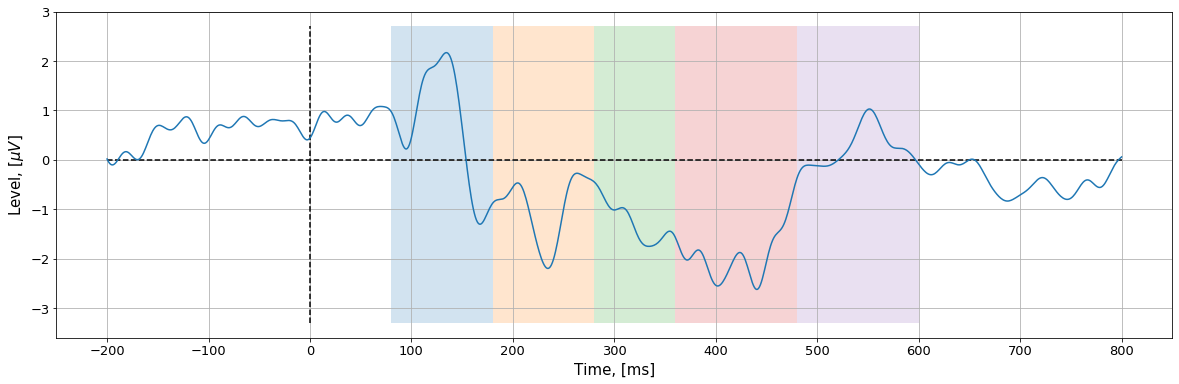

Files Loaded:  S01.edf.mrk S01.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S02.edf.mrk S02.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2357999  =      0.000 ...  2357.999 secs...

=== PLOT ===


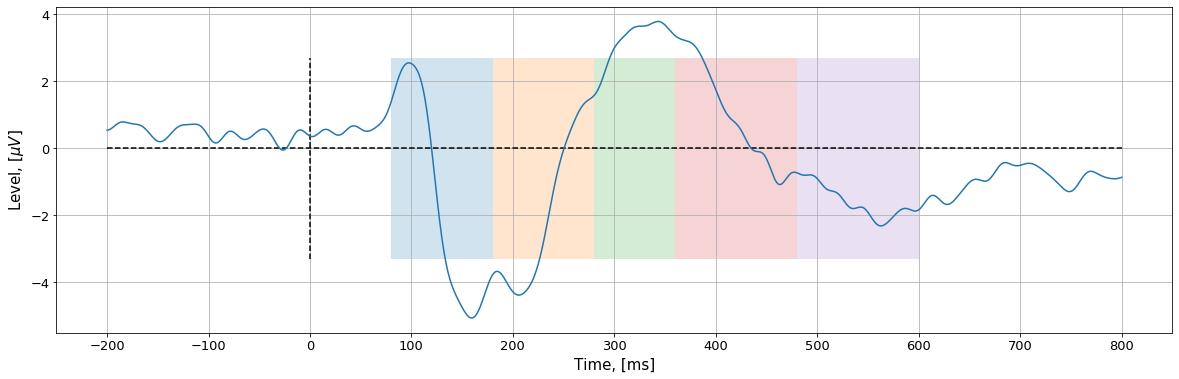

Files Loaded:  S02.edf.mrk S02.edf
Events number in record:  176
Columns Name:  RangeIndex(start=0, stop=176, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S03.edf.mrk S03.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1855999  =      0.000 ...  1855.999 secs...

=== PLOT ===


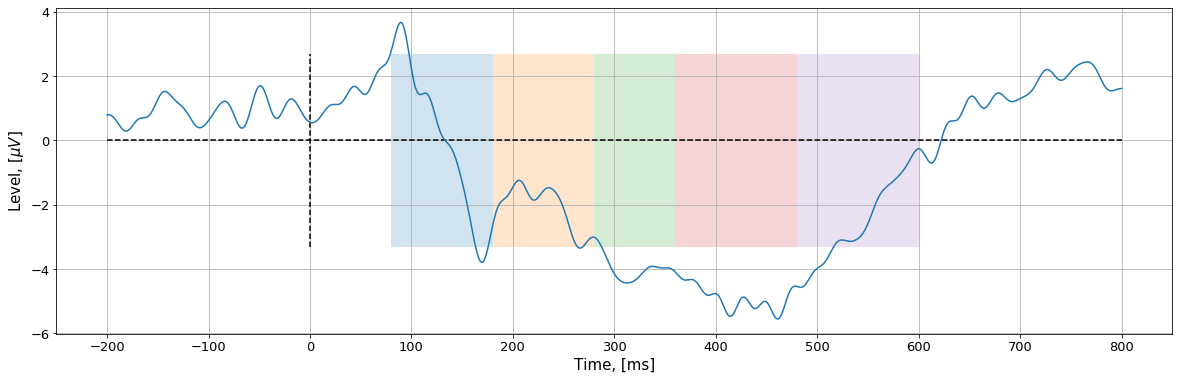

Files Loaded:  S03.edf.mrk S03.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S04.edf.mrk S04.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1829999  =      0.000 ...  1829.999 secs...

=== PLOT ===


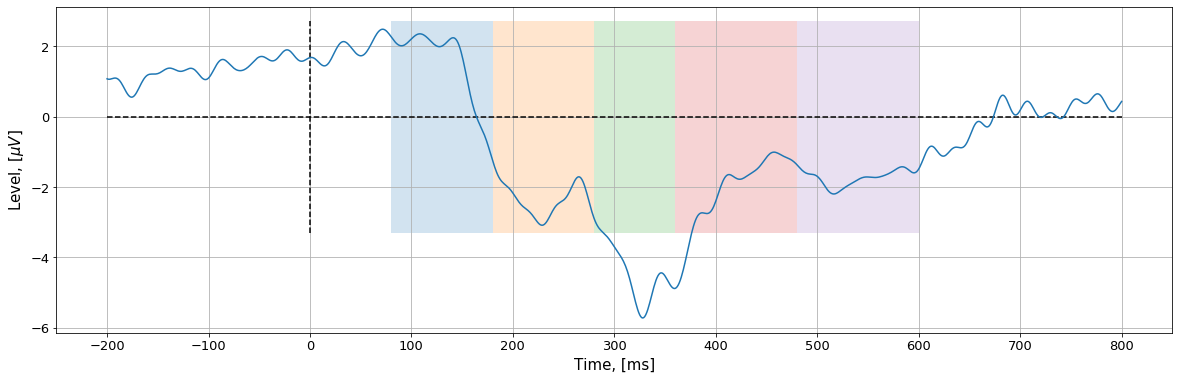

Files Loaded:  S04.edf.mrk S04.edf
Events number in record:  179
Columns Name:  RangeIndex(start=0, stop=179, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S05.edf.mrk S05.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1981999  =      0.000 ...  1981.999 secs...

=== PLOT ===


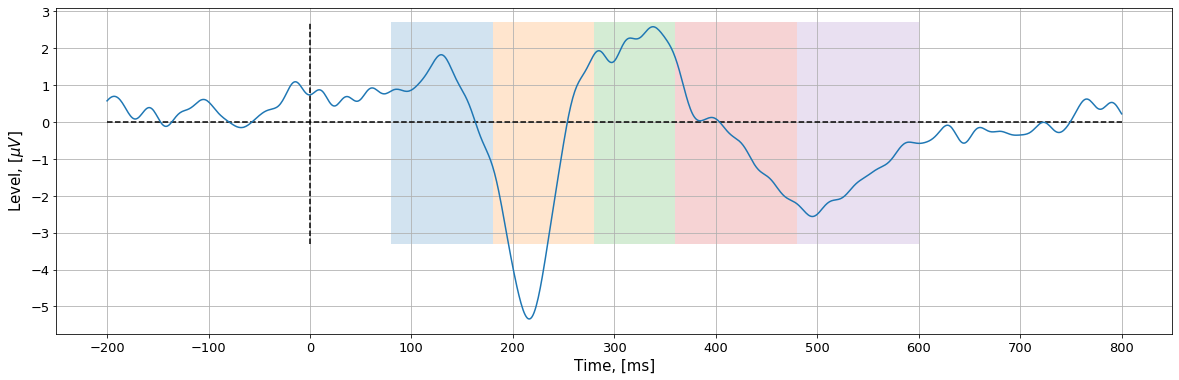

Files Loaded:  S05.edf.mrk S05.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S06.edf.mrk S06.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2379999  =      0.000 ...  2379.999 secs...

=== PLOT ===


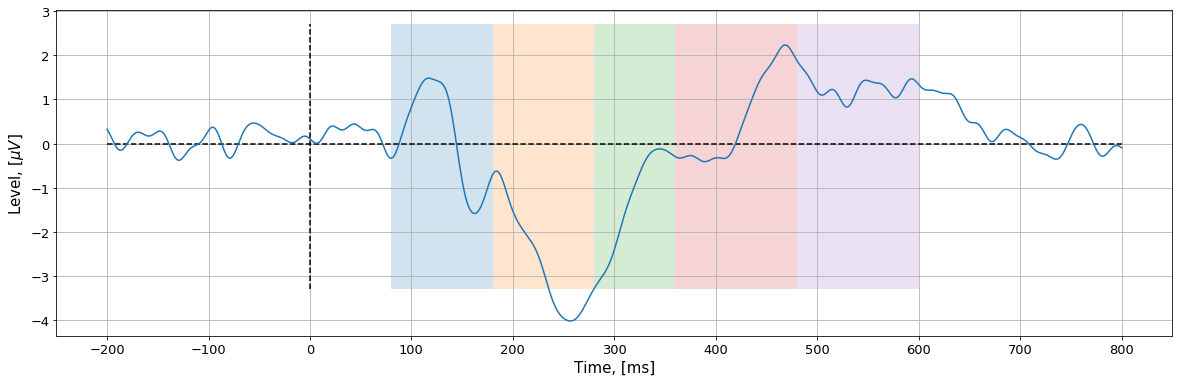

Files Loaded:  S06.edf.mrk S06.edf
Events number in record:  179
Columns Name:  RangeIndex(start=0, stop=179, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S07.edf.mrk S07.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1994999  =      0.000 ...  1994.999 secs...

=== PLOT ===


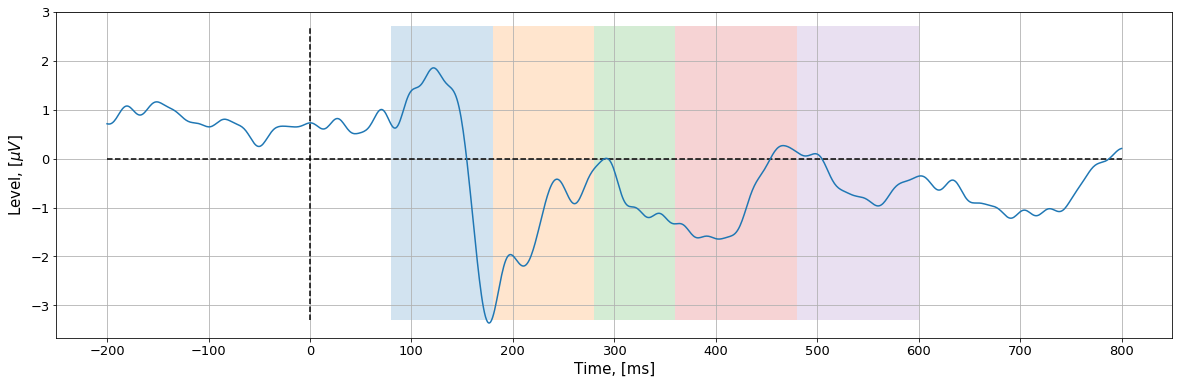

Files Loaded:  S07.edf.mrk S07.edf
Events number in record:  199
Columns Name:  RangeIndex(start=0, stop=199, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S08.edf.mrk S08.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2145999  =      0.000 ...  2145.999 secs...

=== PLOT ===


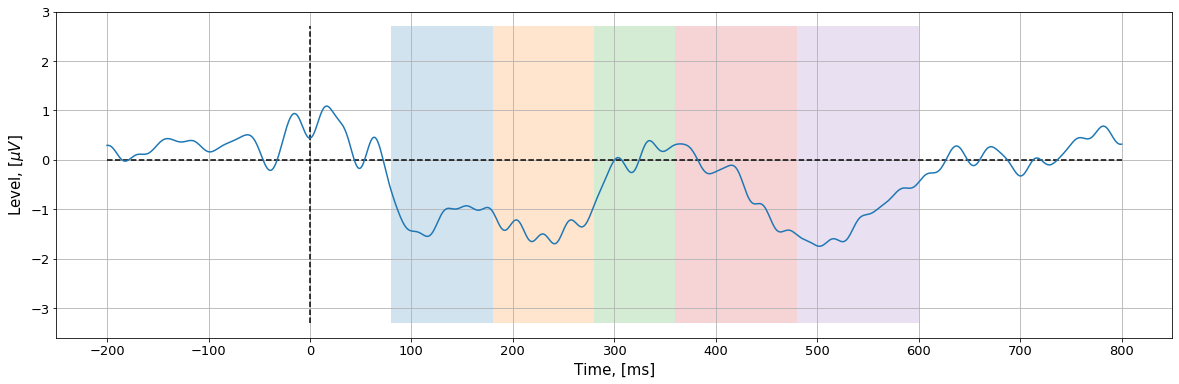

Files Loaded:  S08.edf.mrk S08.edf
Events number in record:  194
Columns Name:  RangeIndex(start=0, stop=194, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S09.edf.mrk S09.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1850999  =      0.000 ...  1850.999 secs...

=== PLOT ===


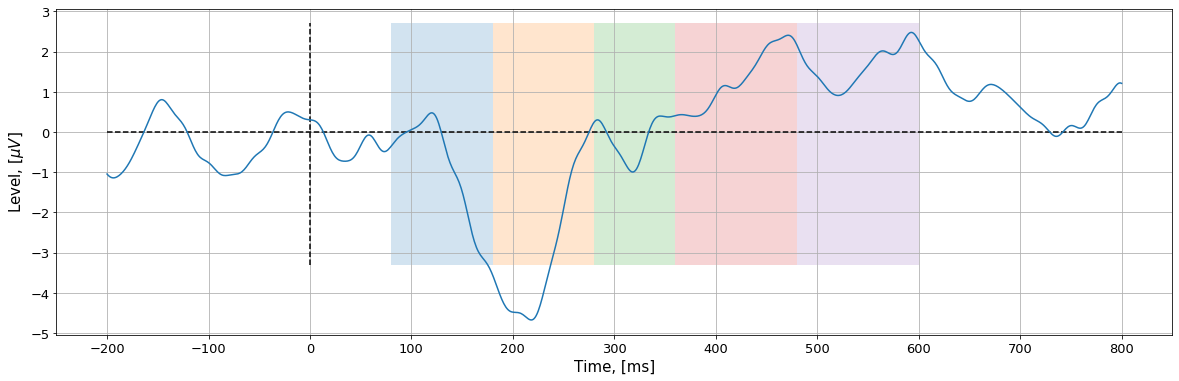

Files Loaded:  S09.edf.mrk S09.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S10.edf.mrk S10.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1924999  =      0.000 ...  1924.999 secs...

=== PLOT ===


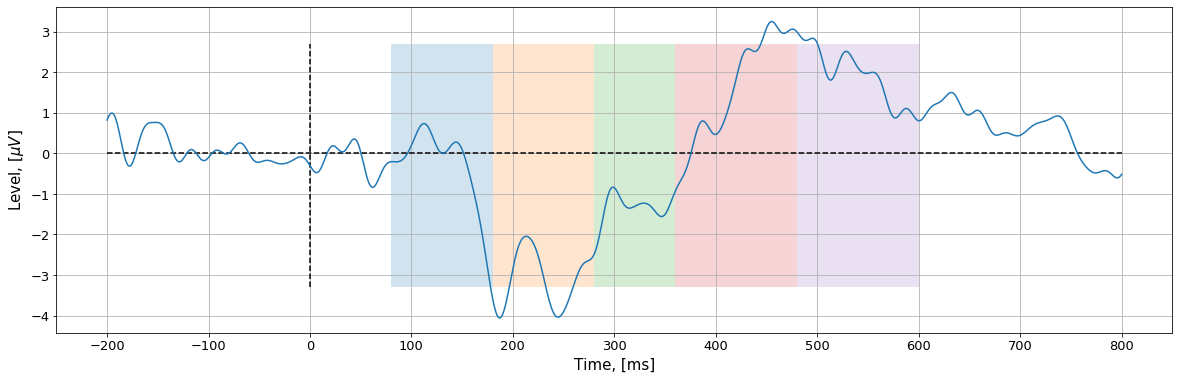

Files Loaded:  S10.edf.mrk S10.edf
Events number in record:  197
Columns Name:  RangeIndex(start=0, stop=197, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S11.edf.mrk S11.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1715999  =      0.000 ...  1715.999 secs...

=== PLOT ===


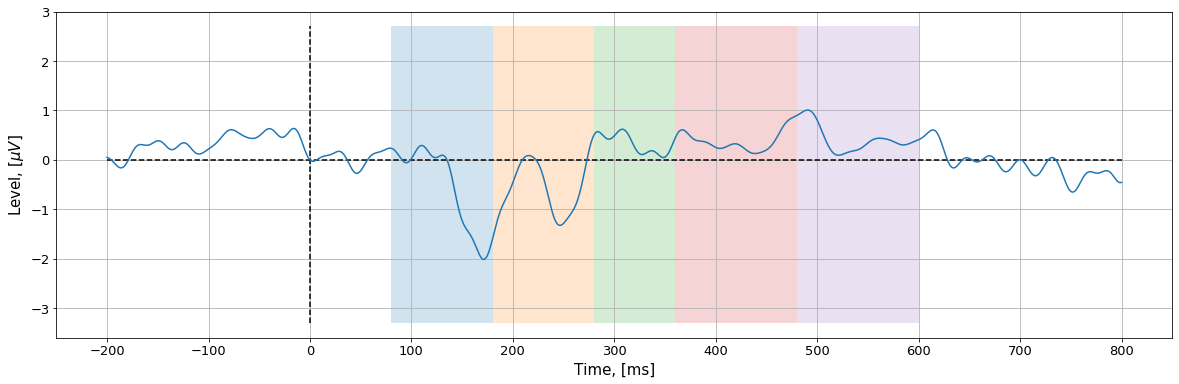

Files Loaded:  S11.edf.mrk S11.edf
Events number in record:  198
Columns Name:  RangeIndex(start=0, stop=198, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S12.edf.mrk S12.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2035999  =      0.000 ...  2035.999 secs...

=== PLOT ===


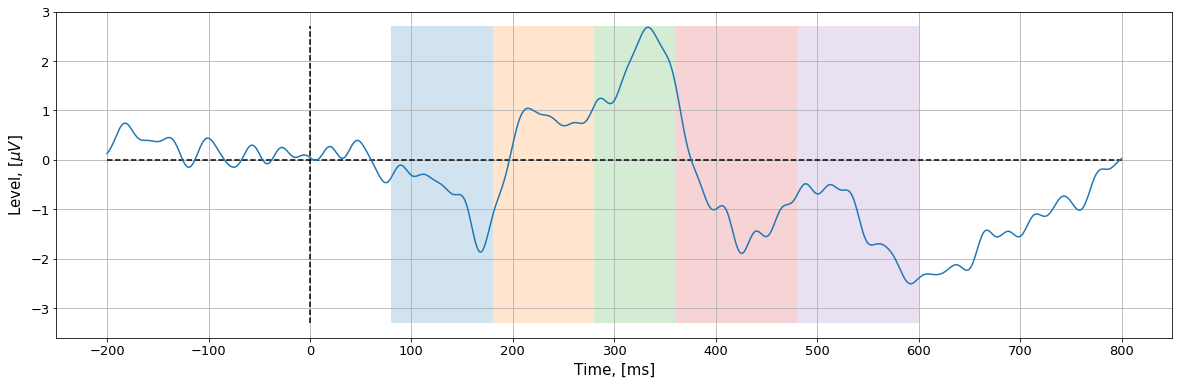

Files Loaded:  S12.edf.mrk S12.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S13.edf.mrk S13.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1924999  =      0.000 ...  1924.999 secs...

=== PLOT ===


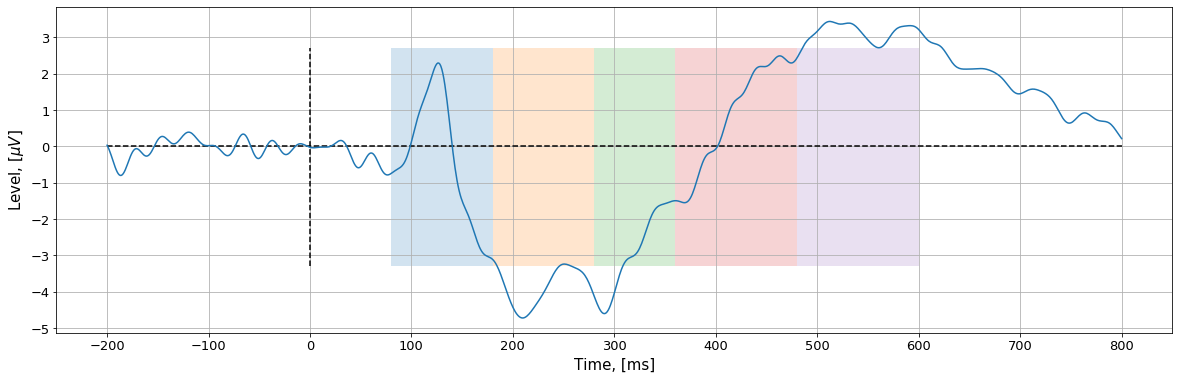

Files Loaded:  S13.edf.mrk S13.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S14.edf.mrk S14.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 1928999  =      0.000 ...  1928.999 secs...

=== PLOT ===


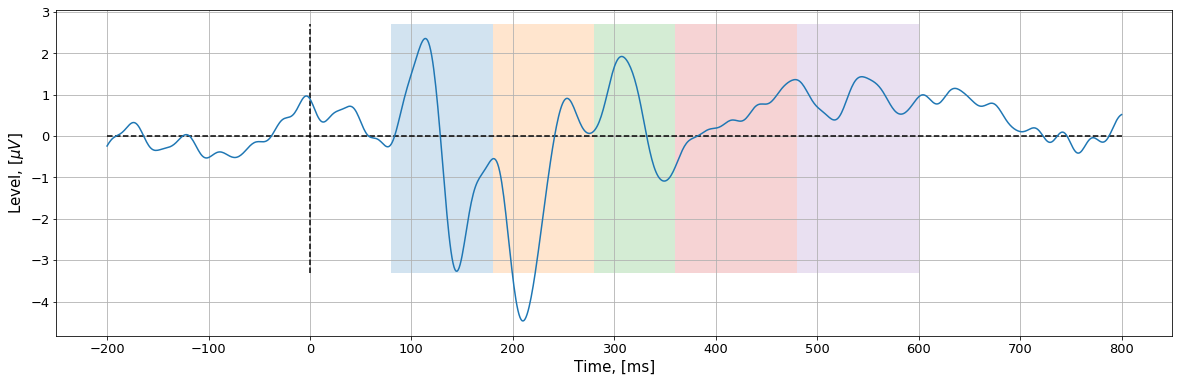

Files Loaded:  S14.edf.mrk S14.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S15.edf.mrk S15.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2104999  =      0.000 ...  2104.999 secs...

=== PLOT ===


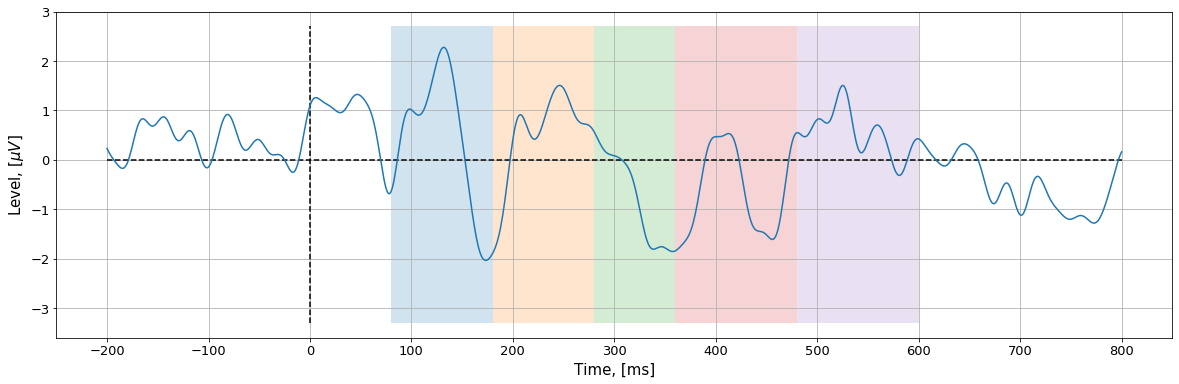

Files Loaded:  S15.edf.mrk S15.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S16.edf.mrk S16.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2002999  =      0.000 ...  2002.999 secs...

=== PLOT ===


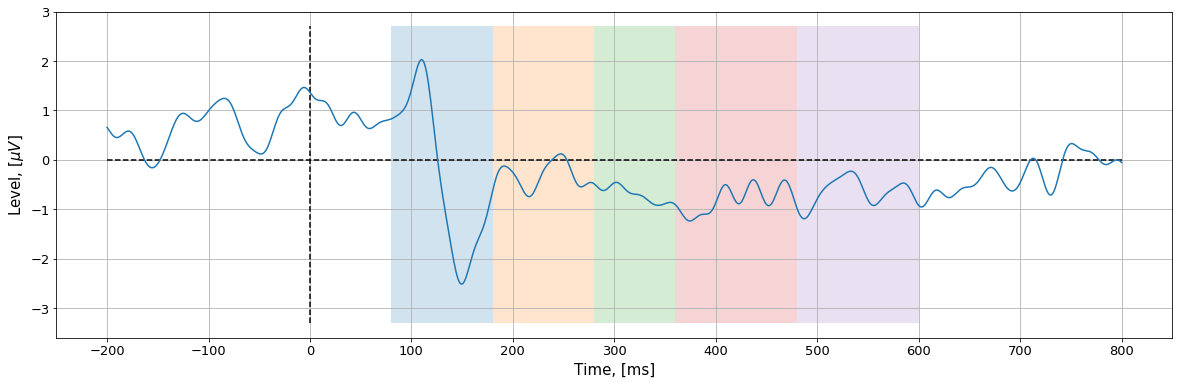

Files Loaded:  S16.edf.mrk S16.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S17.edf.mrk S17.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2215999  =      0.000 ...  2215.999 secs...

=== PLOT ===


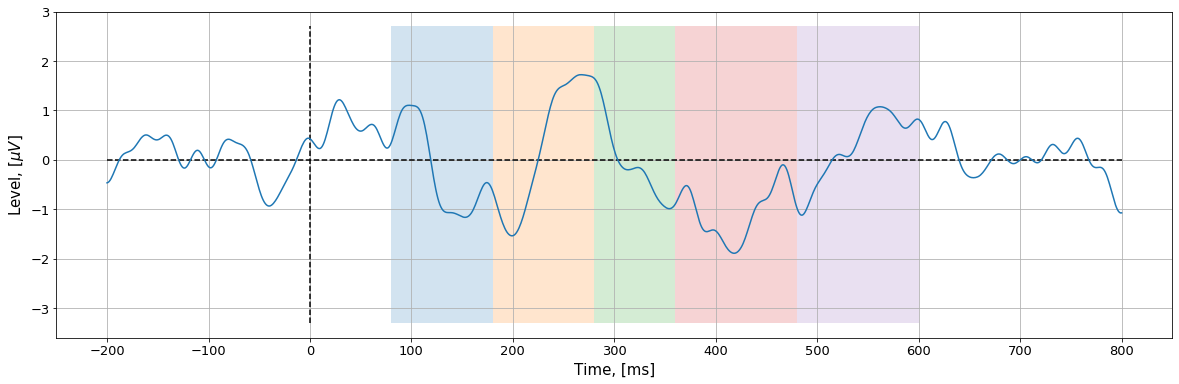

Files Loaded:  S17.edf.mrk S17.edf
Events number in record:  196
Columns Name:  RangeIndex(start=0, stop=196, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S18.edf.mrk S18.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2109999  =      0.000 ...  2109.999 secs...

=== PLOT ===


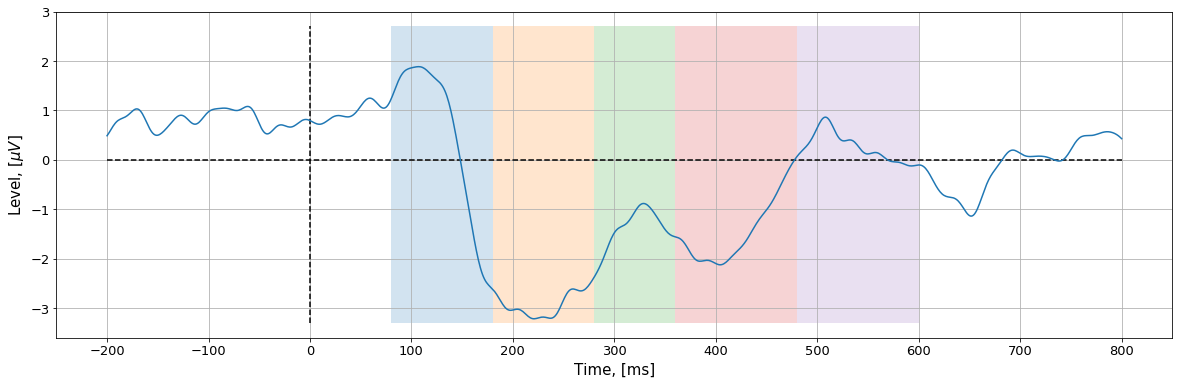

Files Loaded:  S18.edf.mrk S18.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S19.edf.mrk S19.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2095999  =      0.000 ...  2095.999 secs...

=== PLOT ===


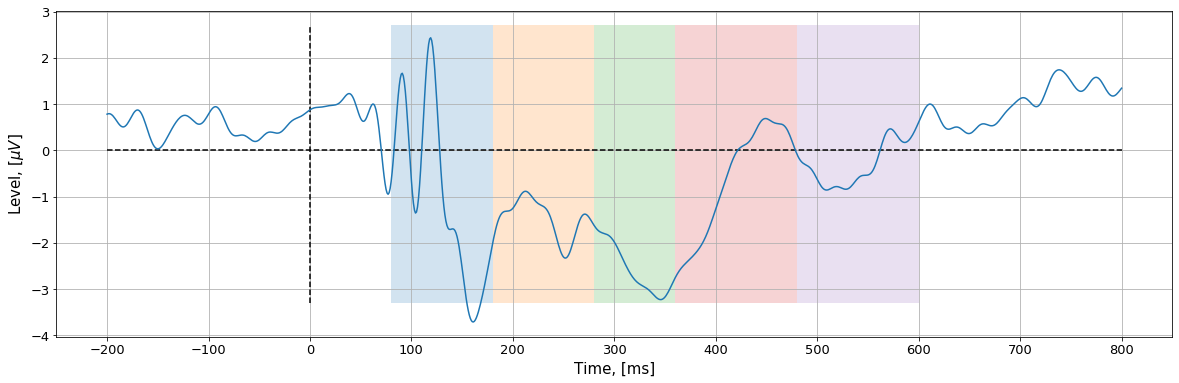

Files Loaded:  S19.edf.mrk S19.edf
Events number in record:  200
Columns Name:  RangeIndex(start=0, stop=200, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '




Files Loading:  S20.edf.mrk S20.edf


<ipython-input-3-bfc5ec795950>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tmin['index'] = pd.DataFrame(np.arange(1001, 2001))


Extracting EDF parameters from C:\Users\dkornev\Desktop\Work Folder\My Folders\Harrisburg University\ISEM 780-52-A-2021 Fall - Doctoral Research Seminar\Experiment_1\S20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

=== FILTER ===
Reading 0 ... 2218999  =      0.000 ...  2218.999 secs...

=== PLOT ===


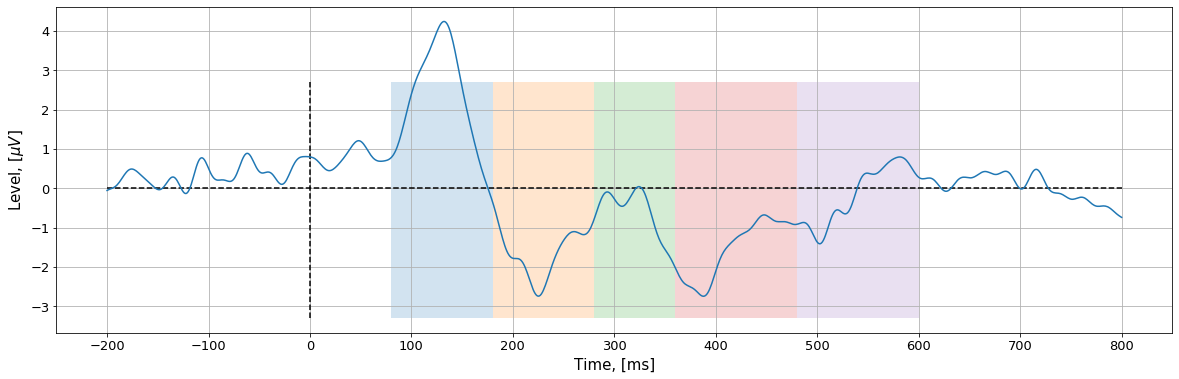

Files Loaded:  S20.edf.mrk S20.edf
Events number in record:  194
Columns Name:  RangeIndex(start=0, stop=194, step=1)



C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\dkornev\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 121, using nperseg = 121
  warnings.warn('nperseg = {0:d} is greater than input length '


In [27]:
peaks_features_ERN,  peaks_features_P200, peaks_features_FRN, peaks_features_P300, peaks_features_N500, \
  dwt_features_ERN,    dwt_features_P200,   dwt_features_FRN,   dwt_features_P300,   dwt_features_N500, \
  cwt_features_ERN,    cwt_features_P200,   cwt_features_FRN,   cwt_features_P300,   cwt_features_N500, \
  y = get_signal_features(data_dir = './', 
                          cwt_waveletname = 'morl', 
                          dwt_waveletname = 'db4', 
                          denominator = 10, 
                          percentile = 5, 
                          n_peaks = 50)

In [28]:
np.array(dwt_features_ERN).shape, np.array(dwt_features_P200).shape, np.array(dwt_features_FRN).shape, np.array(dwt_features_P300).shape, np.array(dwt_features_N500).shape

((3912, 132), (3912, 132), (3912, 132), (3912, 165), (3912, 165))

In [29]:
np.array(cwt_features_ERN).shape, np.array(cwt_features_P200).shape, np.array(cwt_features_FRN).shape, np.array(cwt_features_P300).shape, np.array(cwt_features_N500).shape

((3912, 128, 101),
 (3912, 128, 101),
 (3912, 128, 81),
 (3912, 128, 121),
 (3912, 128, 121))

In [30]:
np.array(peaks_features_ERN).shape, np.array(peaks_features_P200).shape, np.array(peaks_features_FRN).shape, np.array(peaks_features_P300).shape, np.array(peaks_features_N500).shape

((3912, 300), (3912, 300), (3912, 300), (3912, 300), (3912, 300))

In [31]:
np.array(y).shape, np.unique(y)

((3912,), array([0, 1]))

# **5.0 ML Application** 

In [32]:
def plot_history_acc(history):
    plt.plot(history.history['accuracy'], 
            label='accuracy on training set')
    plt.plot(history.history['val_accuracy'], 
            label='accuracy on validation set')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

def plot_history_loss(history):
    plt.plot(history.history['loss'], 
         label='loss on training set')
    plt.plot(history.history['val_loss'], 
         label='loss on validation set')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [33]:
def STANDARDIZATION(X):
    PredictorScaler = StandardScaler()
    PredictorScalerFit = PredictorScaler.fit(X)
    X = PredictorScalerFit.transform(X)
    return X

In [34]:
# Normalization
peaks_features_ERN_norm = preprocessing.normalize(peaks_features_ERN)
cwt_features_ERN_norm   = np.array(cwt_features_ERN) / np.sqrt(np.sum((np.array(cwt_features_ERN))**2))
dwt_features_ERN_norm   = preprocessing.normalize(dwt_features_ERN)

peaks_features_P200_norm = preprocessing.normalize(peaks_features_P200)
cwt_features_P200_norm   = np.array(cwt_features_P200) / np.sqrt(np.sum((np.array(cwt_features_P200))**2))
dwt_features_P200_norm   = preprocessing.normalize(dwt_features_P200)

peaks_features_FRN_norm = preprocessing.normalize(peaks_features_FRN)
cwt_features_FRN_norm   = np.array(cwt_features_FRN) / np.sqrt(np.sum((np.array(cwt_features_FRN))**2))
dwt_features_FRN_norm   = preprocessing.normalize(dwt_features_FRN)

peaks_features_P300_norm = preprocessing.normalize(peaks_features_P300)
cwt_features_P300_norm   = np.array(cwt_features_P300) / np.sqrt(np.sum((np.array(cwt_features_P300))**2))
dwt_features_P300_norm   = preprocessing.normalize(dwt_features_P300)

peaks_features_N500_norm = preprocessing.normalize(peaks_features_N500)
cwt_features_N500_norm   = np.array(cwt_features_N500) / np.sqrt(np.sum((np.array(cwt_features_N500))**2))
dwt_features_N500_norm   = preprocessing.normalize(dwt_features_N500)

In [35]:
def ANNclassifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    D = X_train.shape[1]
    
    history = History()
    
    classifier = Sequential()
    
    classifier.add(Dense(units=10, input_dim=D, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dropout(0.3, input_shape=(X_train.shape[1],))) 
    classifier.add(Dense(units=8, kernel_initializer='normal', activation='relu'))
    classifier.add(Dropout(0.3))
    classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    classifier.compile(loss=tf.keras.losses.BinaryCrossentropy(reduction='none'), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])
    
    history = classifier.fit(X_train, y_train, batch_size=800, epochs=70, verbose=0, validation_data=(X_test, y_test), shuffle=True, callbacks=[history])
    train_score = classifier.evaluate(X_train, y_train, verbose=0)
    test_score = classifier.evaluate(X_test, y_test, verbose=0)
    
    return train_score[1], test_score[1]

In [42]:
def RFclassifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    clf = RandomForestClassifier(n_estimators=1000)
    clf.fit(X_train, y_train)
    
    return clf.score(X_train, y_train), clf.score(X_test, y_test)

In [37]:
def SVMclassifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    clf = svm.SVC(kernel='rbf', C=1, random_state=42)
    clf.fit(X_train, y_train)
    
    return clf.score(X_train, y_train), clf.score(X_test, y_test)

In [38]:
def CNNclassifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    X_train = np.expand_dims(X_train, axis = -1)
    X_test = np.expand_dims(X_test, axis = -1)   
    D = X_train.shape[1]
    
    history = History()
    
    img_x = D
    img_y = 1
    input_shape = (img_x, img_y)
    
    num_classes = 2
    batch_size = 800
    epochs = 100
    
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
 
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)
 
    model = Sequential()
    model.add(Conv1D(32, kernel_size=5, strides=1, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(SpatialDropout1D(0.6))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(SpatialDropout1D(0.6))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(reduction='none'), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, y_test), 
          shuffle=True, 
          callbacks=[history])
 
    train_score = model.evaluate(X_train, y_train, verbose=0)
    test_score = model.evaluate(X_test, y_test, verbose=0)
    y_test_pred = (model.predict(X_test) > 0.5).astype(int)
    
    return train_score[1], test_score[1]

In [39]:
def CNNclassifier3D(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    X_train = np.expand_dims(X_train, axis = -1)
    X_test = np.expand_dims(X_test, axis = -1)   
    D1 = X_train.shape[1]
    D2 = X_train.shape[2]
    
    history = History() 
    
    img_x = D1
    img_y = D2
    img_z = 1
    input_shape = (img_x, img_y, img_z) 
    
    num_classes = 2
    batch_size = 800
    epochs = 70
 
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)
 
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, y_test), 
          shuffle=True, 
          callbacks=[history])
 
    train_score = model.evaluate(X_train, y_train, verbose=0)
    test_score = model.evaluate(X_test, y_test, verbose=0)
    y_test_pred = (model.predict(X_test) > 0.5).astype(int)
    
    return train_score[1], test_score[1]

In [40]:
#### 1 peaks_features_ERN ###

In [41]:
X_peaks_ern  = STANDARDIZATION(peaks_features_ERN)
X_peaks_p200 = STANDARDIZATION(peaks_features_P200)
X_peaks_frn  = STANDARDIZATION(peaks_features_FRN)
X_peaks_p300 = STANDARDIZATION(peaks_features_P300)
X_peaks_n500 = STANDARDIZATION(peaks_features_N500)
y = np.array(y)

print('peaks_features_ERN')
resultANN = ANNclassifier(X_peaks_ern, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_peaks_ern, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_peaks_ern, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_peaks_ern, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('peaks_features_P200')
resultANN = ANNclassifier(X_peaks_p200, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_peaks_p200, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_peaks_p200, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_peaks_p200, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('peaks_features_FRN')
resultANN = ANNclassifier(X_peaks_frn, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_peaks_frn, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_peaks_frn, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_peaks_frn, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('peaks_features_P300')
resultANN = ANNclassifier(X_peaks_p300, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_peaks_p300, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_peaks_p300, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_peaks_p300, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('peaks_features_N500')
resultANN = ANNclassifier(X_peaks_n500, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_peaks_n500, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_peaks_n500, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_peaks_n500, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

peaks_features_ERN
ANN: Train accuracy: 0.6139752864837646, Test accuracy: 0.5948881506919861
RF : Train accuracy: 0.9974435449510013, Test accuracy: 0.5897763578274761
SVM: Train accuracy: 0.6216446527481891, Test accuracy: 0.579552715654952
CNN: Train accuracy: 0.7230507135391235, Test accuracy: 0.5795527100563049

peaks_features_P200
ANN: Train accuracy: 0.6293140053749084, Test accuracy: 0.5757188200950623
RF : Train accuracy: 0.9987217724755006, Test accuracy: 0.602555910543131
SVM: Train accuracy: 0.6638261610566681, Test accuracy: 0.5757188498402556
CNN: Train accuracy: 0.7443544864654541, Test accuracy: 0.5980830788612366

peaks_features_FRN
ANN: Train accuracy: 0.631870448589325, Test accuracy: 0.5757188200950623
RF : Train accuracy: 0.9880698764380059, Test accuracy: 0.5916932907348242
SVM: Train accuracy: 0.6493395824456754, Test accuracy: 0.594888178913738
CNN: Train accuracy: 0.6787388324737549, Test accuracy: 0.5833866000175476

peaks_features_P300
ANN: Train accuracy: 0.

In [43]:
## 2 DWT features ###

In [44]:
X_dwt_ern  = STANDARDIZATION(dwt_features_ERN)
X_dwt_p200 = STANDARDIZATION(dwt_features_P200)
X_dwt_frn  = STANDARDIZATION(dwt_features_FRN)
X_dwt_p300 = STANDARDIZATION(dwt_features_P300)
X_dwt_n500 = STANDARDIZATION(dwt_features_N500)
y = np.array(y)

print('dwt_features_ERN')
resultANN = ANNclassifier(X_dwt_ern, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_dwt_ern, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_dwt_ern, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_dwt_ern, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('dwt_features_P200')
resultANN = ANNclassifier(X_dwt_p200, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_dwt_p200, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_dwt_p200, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_dwt_p200, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('dwt_features_FRN')
resultANN = ANNclassifier(X_dwt_frn, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_dwt_frn, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_dwt_frn, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_dwt_frn, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('dwt_features_P300')
resultANN = ANNclassifier(X_dwt_p300, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_dwt_p300, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_dwt_p300, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_dwt_p300, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('dwt_features_N500')
resultANN = ANNclassifier(X_dwt_n500, y)
print('ANN: Train accuracy: {}, Test accuracy: {}'.format(resultANN[0], resultANN[1]))
resultRF = RFclassifier(X_dwt_n500, y)
print('RF : Train accuracy: {}, Test accuracy: {}'.format(resultRF[0], resultRF[1]))
resultSVM = SVMclassifier(X_dwt_n500, y)
print('SVM: Train accuracy: {}, Test accuracy: {}'.format(resultSVM[0], resultSVM[1]))
resultCNN = CNNclassifier(X_dwt_n500, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

dwt_features_ERN
ANN: Train accuracy: 0.631870448589325, Test accuracy: 0.5488817691802979
RF : Train accuracy: 1.0, Test accuracy: 0.5616613418530352
SVM: Train accuracy: 0.7383894333191308, Test accuracy: 0.5610223642172524
CNN: Train accuracy: 0.7371112108230591, Test accuracy: 0.5591054558753967

dwt_features_P200
ANN: Train accuracy: 0.6697912216186523, Test accuracy: 0.5674121379852295
RF : Train accuracy: 1.0, Test accuracy: 0.5897763578274761
SVM: Train accuracy: 0.7481891776736259, Test accuracy: 0.5776357827476039
CNN: Train accuracy: 0.7635279297828674, Test accuracy: 0.5731629133224487

dwt_features_FRN
ANN: Train accuracy: 0.6544525027275085, Test accuracy: 0.5578274726867676
RF : Train accuracy: 1.0, Test accuracy: 0.5642172523961662
SVM: Train accuracy: 0.7426501917341287, Test accuracy: 0.5610223642172524
CNN: Train accuracy: 0.7673625946044922, Test accuracy: 0.5546326041221619

dwt_features_P300
ANN: Train accuracy: 0.6638261675834656, Test accuracy: 0.567412137985229

In [45]:
## 3 cwt features ##

In [46]:
X_cwt_ern   = np.array(cwt_features_ERN) / np.sqrt(np.sum((np.array(cwt_features_ERN))**2))
X_cwt_p200  = np.array(cwt_features_P200) / np.sqrt(np.sum((np.array(cwt_features_P200))**2))
X_cwt_frn   = np.array(cwt_features_FRN) / np.sqrt(np.sum((np.array(cwt_features_FRN))**2))
X_cwt_p300  = np.array(cwt_features_P300) / np.sqrt(np.sum((np.array(cwt_features_P300))**2))
X_cwt_n500  = np.array(cwt_features_N500) / np.sqrt(np.sum((np.array(cwt_features_N500))**2))
y = np.array(y)

print('cwt_features_ERN')
resultCNN = CNNclassifier3D(X_cwt_ern, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('cwt_features_P200')
resultCNN = CNNclassifier3D(X_cwt_p200, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('cwt_features_FRN')
resultCNN = CNNclassifier3D(X_cwt_frn, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('cwt_features_P300')
resultCNN = CNNclassifier3D(X_cwt_p300, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

print('cwt_features_N500')
resultCNN = CNNclassifier3D(X_cwt_n500, y)
print('CNN: Train accuracy: {}, Test accuracy: {}'.format(resultCNN[0], resultCNN[1]))
print('')

cwt_features_ERN
CNN: Train accuracy: 0.5649765729904175, Test accuracy: 0.5373802185058594

cwt_features_P200
CNN: Train accuracy: 0.5649765729904175, Test accuracy: 0.5373802185058594

cwt_features_FRN


KeyboardInterrupt: 

In [ ]:
#######

In [ ]:
def plot_history_acc(history):
    plt.plot(history.history['accuracy'], 
            label='accuracy on training set')
    plt.plot(history.history['val_accuracy'], 
            label='accuracy on testing set')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

def plot_history_loss(history):
    plt.plot(history.history['loss'], 
         label='loss on training set')
    plt.plot(history.history['val_loss'], 
         label='loss on testing set')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [51]:
X_dwt_ern  = STANDARDIZATION(peaks_features_P300)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X_dwt_ern, y, test_size=0.3, random_state=42)
D = X_train.shape[1]

86/86 [==============================] - 0s 2ms/step - loss: 0.4978 - accuracy: 0.7356
Train loss: 0.4977508783340454, Train accuracy: 0.735573410987854
37/37 [==============================] - 0s 1ms/step - loss: 1.0766 - accuracy: 0.6065
Test loss: 1.0765564441680908, Test accuracy: 0.6064735651016235
              precision    recall  f1-score   support

           0       0.69      0.46      0.55       618
           1       0.56      0.77      0.65       556

    accuracy                           0.61      1174
   macro avg       0.63      0.61      0.60      1174
weighted avg       0.63      0.61      0.60      1174

[[430 126]
 [336 282]]


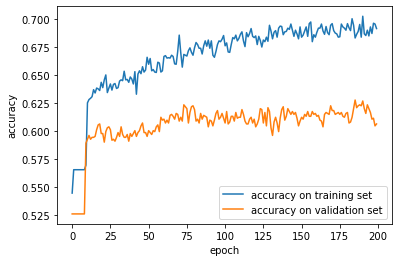

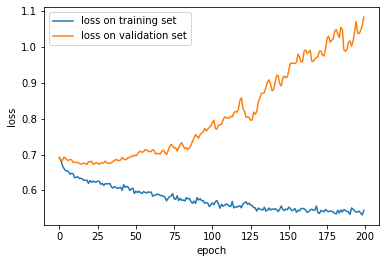

In [52]:
history = History()
classifier = Sequential()
classifier.add(Dense(units=10, input_dim=D, kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(0.3, input_shape=(X_train.shape[1],))) 
classifier.add(Dense(units=8, kernel_initializer='normal', activation='relu'))
classifier.add(Dropout(0.3))
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
classifier.compile(loss=tf.keras.losses.BinaryCrossentropy(reduction='none'), 
                   optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), 
                   metrics=['accuracy'])
history = classifier.fit(X_train, y_train, 
                         batch_size=800, 
                         epochs=200, 
                         verbose=0, 
                         validation_data=(X_test, y_test), 
                         shuffle=True, callbacks=[history])

train_score = classifier.evaluate(X_train, y_train, verbose=1)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = classifier.evaluate(X_test, y_test, verbose=1)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

y_test_pred = (classifier.predict(X_test) > 0.5).astype(int)

print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred, labels=[1,0]))

plot_history_acc(history)
plot_history_loss(history)

In [ ]:
pred = classifier.predict(X_train)

print((abs(pred - y_train)).mean())  
print(mean_absolute_error(pred, y_train)) 

In [ ]:
def eval_net(model, X_train, y_train, y_scaler = None, n = 10, limit = 2.):
  
    pred = model.predict(X_train)             # Предсказание на тренировочной выборке
    if y_scaler:                              # Если есть нормирование - то денормировать
        pred = y_scaler.inverse_transform(pred)

    print('Средняя абсолютная ошибка:', mean_absolute_error(pred, y_train), '\n')

    
    # Построение картинки разброса предсказанных и верных значений зарплаты
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_train, pred)                 # Отрисовка точечного графика
    ax.set_xlim(0, limit)                     # Пределы по x, y
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')      # Отрисовка диагональной линии
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show() 

In [ ]:
eval_net(classifier, X_train, y_train)

In [ ]:
!pip install scikit-plot==0.3.7
import scikitplot as skplt

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, y_test_pred, normalize=False, title = 'Confusion Matrix')

In [ ]:
y_pred_proba = classifier.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_test_pred)

plt.figure(figsize=(6, 6))
plt.plot(fpr,tpr,label="AUC="+str(auc))

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import RocCurveDisplay

In [ ]:
RocCurveDisplay.from_predictions(
   y_test, y_test_pred)

plt.show()

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

y_pred_proba = classifier.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
clf = RandomForestClassifier(n_estimators=10000)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print("Accuracy on training set is : {}".format(clf.score(X_train, y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test, y_test)))
print(classification_report(y_test, y_test_pred))

In [ ]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_test_pred)

plt.figure(figsize=(6, 6))
plt.plot(fpr,tpr,label="AUC="+str(auc))

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, y_test_pred, normalize=False, title = 'Confusion Matrix')

In [ ]:
from PIL import Image 
import PIL 

In [ ]:
img = skplt.metrics.plot_confusion_matrix(y_test, y_test_pred, normalize=False, title = 'Confusion Matrix')

In [ ]:
#########################

In [53]:
X = np.array(peaks_features_P300)
y = np.array(y)
 
 
### Sandardization of data ###
### We does not standardize the Target variable for classification
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
 
# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)
 
# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
 
# Quick sanity check with the shapes of Training and Testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2347, 300)
(2347,)
(1565, 300)
(1565,)


74/74 [==============================] - 0s 1ms/step - loss: 0.5635 - accuracy: 0.6890
Train loss: 0.5634840130805969, Train accuracy: 0.6889646649360657
49/49 [==============================] - 0s 1ms/step - loss: 0.7200 - accuracy: 0.5840
Test loss: 0.7200005054473877, Test accuracy: 0.5840255618095398
              precision    recall  f1-score   support

           0       0.66      0.46      0.54       841
           1       0.54      0.73      0.62       724

    accuracy                           0.58      1565
   macro avg       0.60      0.59      0.58      1565
weighted avg       0.60      0.58      0.58      1565

[[526 198]
 [453 388]]


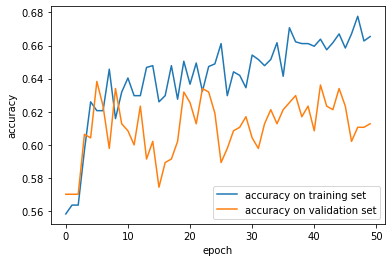

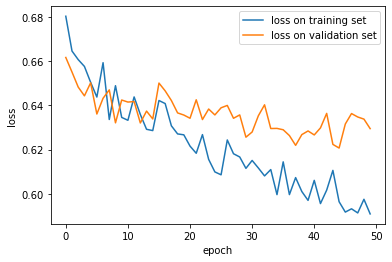

In [54]:
history = History()

classifier = Sequential()


classifier.add(Dense(units=10, input_dim=300, kernel_initializer='uniform', activation='relu'))

classifier.add(Dropout(0.3, input_shape=(X_train.shape[1],))) 
classifier.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))

classifier.add(Dropout(0.3))
classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))

classifier.add(Dropout(0.3))
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

classifier.compile(loss=tf.keras.losses.BinaryCrossentropy(reduction='none'), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), metrics=['accuracy'])

history = classifier.fit(X_train, y_train, batch_size=50, epochs=50, verbose=0, validation_split=0.2, shuffle=True, callbacks=[history])

train_score = classifier.evaluate(X_train, y_train, verbose=1)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = classifier.evaluate(X_test, y_test, verbose=1)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

y_test_pred = (classifier.predict(X_test) > 0.5).astype(int)



print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred, labels=[1,0]))

plot_history_acc(history)
plot_history_loss(history)

In [ ]:
X = np.array(dwt_features_P300)
y = np.array(y)
 
### Standardization of data ###
### We does not standardize the Target variable for classification
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
 
# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)

 
# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
 
# Quick sanity check with the shapes of Training and Testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
history = History()

classifier = Sequential()


classifier.add(Dense(units=10, input_dim=165, kernel_initializer='uniform', activation='relu'))

classifier.add(Dropout(0.3, input_shape=(X_train.shape[1],))) 
classifier.add(Dense(units=8, kernel_initializer='normal', activation='relu'))



classifier.add(Dropout(0.3))
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

classifier.compile(loss=tf.keras.losses.BinaryCrossentropy(reduction='none'), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

history = classifier.fit(X_train, y_train, batch_size=800, epochs=70, verbose=0, validation_data=(X_test, y_test), shuffle=True, callbacks=[history])

train_score = classifier.evaluate(X_train, y_train, verbose=1)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = classifier.evaluate(X_test, y_test, verbose=1)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

y_test_pred = (classifier.predict(X_test) > 0.5).astype(int)



print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred, labels=[1,0]))

plot_history_acc(history)
plot_history_loss(history)

In [ ]:
clf = RandomForestClassifier(n_estimators=10000)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print("Accuracy on training set is : {}".format(clf.score(X_train, y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test, y_test)))
print(classification_report(y_test, y_test_pred))

In [ ]:
clf = svm.SVC(kernel='rbf', C=1, random_state=42)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print("Accuracy on training set is : {}".format(clf.score(X_train, y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test, y_test)))
print(classification_report(y_test, y_test_pred))

In [ ]:
cls = GradientBoostingClassifier(n_estimators=2000)
cls.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print("Accuracy on training set is : {}".format(clf.score(X_train, y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test, y_test)))
print(classification_report(y_test, y_test_pred))

In [ ]:
cls = GradientBoostingClassifier(n_estimators=5000, 
                                 learning_rate = 0.01, 
                                 criterion = 'friedman_mse')
cls.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print("Accuracy on training set is : {}".format(clf.score(X_train, y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test, y_test)))
print(classification_report(y_test, y_test_pred))

In [ ]:
# Normalization
peaks_features_ERN_norm = preprocessing.normalize(peaks_features_ERN)
cwt_features_ERN_norm   = np.array(cwt_features_ERN) / np.sqrt(np.sum((np.array(cwt_features_ERN))**2))
dwt_features_ERN_norm   = preprocessing.normalize(dwt_features_ERN)

peaks_features_P200_norm = preprocessing.normalize(peaks_features_P200)
cwt_features_P200_norm   = np.array(cwt_features_P200) / np.sqrt(np.sum((np.array(cwt_features_P200))**2))
dwt_features_P200_norm   = preprocessing.normalize(dwt_features_P200)

peaks_features_FRN_norm = preprocessing.normalize(peaks_features_FRN)
cwt_features_FRN_norm   = np.array(cwt_features_FRN) / np.sqrt(np.sum((np.array(cwt_features_FRN))**2))
dwt_features_FRN_norm   = preprocessing.normalize(dwt_features_FRN)

peaks_features_P300_norm = preprocessing.normalize(peaks_features_P300)
cwt_features_P300_norm   = np.array(cwt_features_P300) / np.sqrt(np.sum((np.array(cwt_features_P300))**2))
dwt_features_P300_norm   = preprocessing.normalize(dwt_features_P300)

peaks_features_N500_norm = preprocessing.normalize(peaks_features_N500)
cwt_features_N500_norm   = np.array(cwt_features_N500) / np.sqrt(np.sum((np.array(cwt_features_N500))**2))
dwt_features_N500_norm   = preprocessing.normalize(dwt_features_N500)

In [ ]:
X = np.array(dwt_features_P300_norm)
y = np.array(y)

# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
 
# Quick sanity check with the shapes of Training and Testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print('___________________')
X_train = np.expand_dims(X_train, axis = -1)
X_test = np.expand_dims(X_test, axis = -1)
X_train.shape, X_test.shape

In [ ]:
# with NORM function
history = History()

img_x = 165
img_y = 1

input_shape = (img_x, img_y)

num_classes = 2
batch_size = 800
epochs = 100
 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
 
model = Sequential()
model.add(Conv1D(32, kernel_size=5, strides=1,
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(Conv1D(64, 5, activation='relu'))
model.add(SpatialDropout1D(0.6))

model.add(Conv1D(64, 5, activation='relu'))
model.add(SpatialDropout1D(0.6))



model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())



model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
 
model.compile(loss=tf.keras.losses.BinaryCrossentropy(reduction='none'), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, y_test), 
          shuffle=True, 
          callbacks=[history])
 
train_score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))
y_test_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_test_pred))

plot_history_acc(history)
plot_history_loss(history)

In [ ]:
# CWT, 3D array

X = np.array(cwt_features_P300_norm)
y = np.array(y)
 
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
 
# Quick sanity check with the shapes of Training and Testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print('___________________')
X_train = np.expand_dims(X_train, axis = -1)
X_test = np.expand_dims(X_test, axis = -1)
X_train.shape, X_test.shape

In [ ]:
history = History()
 
img_x = 128
img_y = 221
img_z = 1
input_shape = (img_x, img_y, img_z)
 
num_classes = 2
batch_size = 800
epochs = 70
 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
    
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))




model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))


model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(Conv2D(64, (5, 5), activation='relu'))


model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
 
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[history])
 
train_score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))
y_test_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_test_pred))

plot_history_acc(history)
plot_history_loss(history)

In [ ]:
history = History()
 
img_x = 128
img_y = 221
img_z = 1
input_shape = (img_x, img_y, img_z)
 
num_classes = 2
batch_size = 800
epochs = 70
 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
 
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
 
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[history])
 
train_score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))
y_test_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_test_pred))

plot_history_acc(history)
plot_history_loss(history)

In [ ]:
raw = mne.io.read_raw_edf('./S01.edf')
raw
raw.plot()

In [ ]:
raw.plot()

In [ ]:
raw_drop = raw.drop_channels(['IO', 'FT9', 'FT7', 'T7', 'TP7', 'TP9', 'FC5', 'CP5', 'FT10', 'FT8', 'T8', 'TP8', 'TP10', 'FC6', 'CP6'])
raw_drop

In [ ]:
builtin_montages = mne.channels.get_builtin_montages()
easycap_montage = mne.channels.make_standard_montage('easycap-M1')

In [ ]:
raw_digit = raw_drop.set_channel_types({'Fp1': 'eeg'})
raw_digit = raw_drop.set_montage(easycap_montage)
raw_digit

In [ ]:
raw_digit.load_data()

# Filtering: low-pass 0.1Hz, High-pass 40Hz
raw_digit_notch = raw_digit.copy().notch_filter(50, verbose='warning')  # notch filter 50 Hz
raw_digit_filt = raw_digit_notch.filter(l_freq=0.1, h_freq=40, fir_design='firwin', skip_by_annotation='edge', verbose='warning') # FIR filter

raw_digit_filt.plot()

In [ ]:
raw_digit.load_data()

# Filtering: low-pass 1Hz, High-pass 40Hz
raw_digit_filt_ica = raw_digit.filter(l_freq=1, h_freq=40, fir_design='firwin', skip_by_annotation='edge', verbose='warning') # FIR filter

In [ ]:
def REJECT(file_eeg_filt_ica):
  tstep = 1.0         # Break raw data into 1 s epochs
  events_ica = mne.make_fixed_length_events(file_eeg_filt_ica, duration=tstep)
  epochs_ica = mne.Epochs(file_eeg_filt_ica, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

  return epochs_ica

In [ ]:
def ICA_REJECT_99(epochs_ica):
  reject_thr = get_rejection_threshold(epochs_ica)
  print('rejection threshold: ', reject_thr)
  ica = ICA(n_components=0.99, max_iter='auto', random_state=97, method='fastica')
  ica.fit(epochs_ica, reject=reject_thr, tstep=1.0)

  return ica

In [ ]:
epochs_ica = REJECT(raw_digit_filt_ica)

In [ ]:
ica = ICA_REJECT_99(epochs_ica)

In [ ]:
ica.plot_components()

In [ ]:
# muscle artifacts

muscle_idx, scores = ica.find_bads_muscle(raw_digit_filt)
ica.plot_scores(muscle_idx, exclude=muscle_idx)
print(f'Automatically found muscle artifact ICA components: {muscle_idx}')


In [ ]:
# eog artifacts
eog_idx, eog_scores = ica.find_bads_eog(raw_digit_filt, ch_name=['Fp1', 'F8'], verbose='warning')
ica.plot_scores(eog_scores)
print(f'Automatically found EOG artifact ICA components: {eog_idx}')

In [ ]:
# ecg artifacts
ecg_indices, ecg_scores = ica.find_bads_ecg(raw_digit_filt, method='correlation', threshold='auto', ch_name='Cz', verbose='warning')
ica.plot_scores(ecg_scores)
print(f'Automatically found ECG artifact ICA components: {ecg_indices}')

In [ ]:
 # ecg artifacts
ecg_idx = [0, 1, 2]  

In [ ]:
file_eeg_filt_clean = ica.apply(raw_digit_filt, exclude = eog_idx + ecg_idx + muscle_idx)
file_eeg_filt_clean.plot()

In [ ]:
igt = pd.read_csv('S01.edf.mrk')

In [ ]:
events = EVENTS(igt)

In [ ]:
file_eeg_filt_reject_ica_clean_frame = FRAME(file_eeg_filt_clean)
EEGdata = EEG(file_eeg_filt_reject_ica_clean_frame, events) 
EEGdata_avg = TOTAL(EEGdata)
EEG_PLOT(EEGdata_avg)

In [ ]:
# S01, FRN signal:
signal  = EEGdata_avg.iloc[280:381, ]

In [ ]:
from scipy.fftpack import fft

In [ ]:
signal

In [ ]:
t_n = 1
N = len(signal)
T = t_n / N
f_s = 1/T 

In [ ]:
f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)

In [ ]:
fft_values_ = fft(signal.values)

In [ ]:
fft_values = 2.0/N * np.abs(fft_values_[0:N//2])

In [ ]:
plt.plot(f_values, fft_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("FFT Function", fontsize=16)
plt.show()

print(f_values.shape, fft_values.shape)

In [ ]:
f_values, psd_values = welch(signal, fs=f_s)

In [ ]:
plt.plot(f_values, psd_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("PSD Function", fontsize=16)
plt.show()

In [ ]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

In [ ]:
def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values

In [ ]:
t_n = 1
N = len(signal)
T = t_n / N
f_s = 1/T

t_values, autocorr_values = get_autocorr_values(signal, T, N, f_s)

In [ ]:
plt.plot(t_values, autocorr_values, linestyle='-', color='blue')
plt.xlabel('Time delay [s]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("ACF Function", fontsize=16)
plt.show()

In [ ]:
max_peak_height = 0.01 * np.nanmax(fft_values)
ind = detect_peaks(fft_values, show=True, mph=max_peak_height)
ind.shape

In [ ]:
max_peak_height = 0.01 * np.nanmax(psd_values)
ind = detect_peaks(psd_values, show=True, mph=max_peak_height)
ind.shape

In [ ]:
max_peak_height = 0.01 * np.nanmax(autocorr_values)
ind = detect_peaks(autocorr_values, show=True, mph=max_peak_height)